## REGRESSION WITH R - PREDICTING SALES VOLUME / PROFITABILITY

<br>


 The sales team is considering to launch 5 new products out of a list of 17. 
<br>
<br>
 Task: Predicting Sales Volume and Profitability with the help of existing products  and the attributes that 
 
 define their market performance.

<br>

 Version 1.0

 Name: Steffen Adolf

 Date: 21.06.2019

### Libraries

In [3]:
library(Amelia)
library(dplyr)
library(corrplot)
library(corrgram)
library(caret)
library(ggplot2)
library(mlbench)
library(RODBC)
library(tidyverse)



### Data Preparation

In [4]:
#reading data sets 

existing2017 <- read.csv('existingproductattributes2017.csv')

incomplete2017 <- read.csv('newproductattributes2017.csv')


In [5]:
#converting "ProductNum" to character (index)

existing2017$ProductNum <- as.character(existing2017$ProductNum)

[1] TRUE

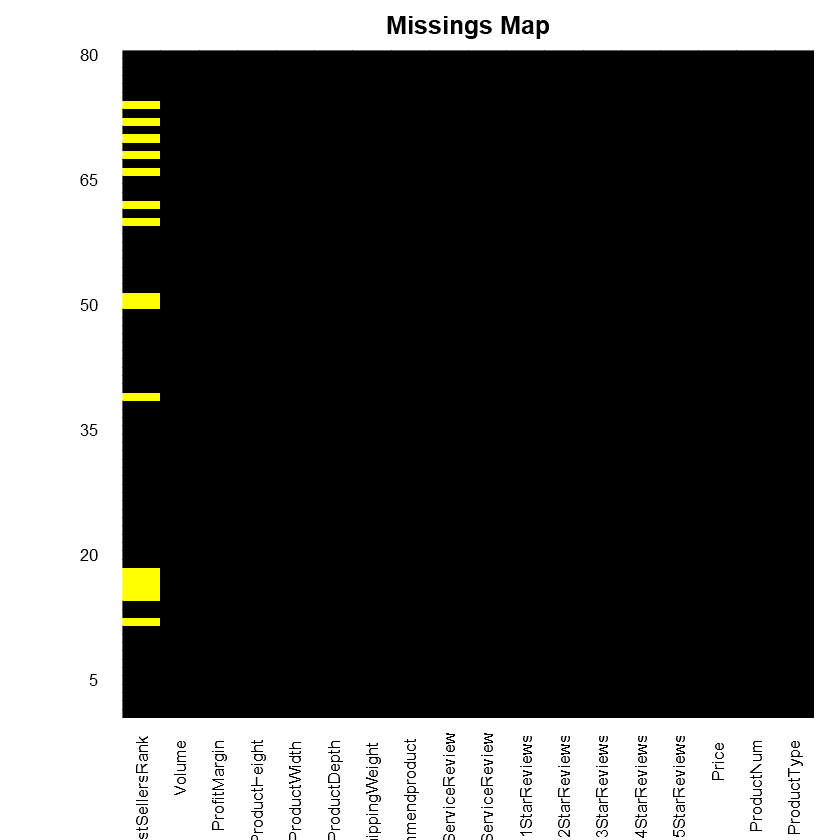

In [6]:
#finding and plotting missing values

any(is.na(existing2017))

missmap(existing2017, main="Missings Map", 
        col=c("yellow", "black"), legend=FALSE)

In [7]:
#removing feature "BestSellersRank" 

existing2017 <- select(existing2017,-c('BestSellersRank'))

### Data Exploration

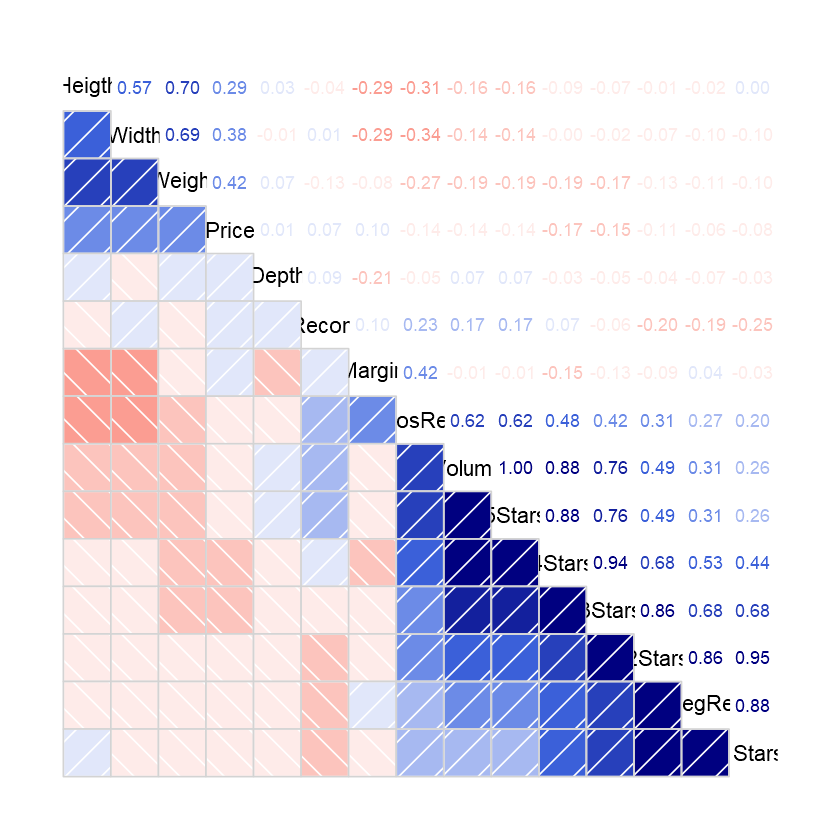

In [8]:
#correlation matrix

num.cols <- sapply(existing2017, is.numeric)

cor.data <- cor(existing2017[,num.cols])

var8 <- c('Price','5Stars','4Stars','3Stars','2Stars','1Stars','PosRev','NegRev',
          'Recom','Weight','Depth','Width','Heigth','Margin','Volume')

existing2017b <- cor.data

colnames(existing2017b)<-var8

corrgram(existing2017b, order = TRUE, lower.panel = panel.shade, upper.panel = panel.cor,
         text.panel = panel.txt, cex = 1.6)

In [9]:
#Feature Selection
# -> Collinearity: removing redudant features  with corr > 0.9

#removing 5StarReviews, 3StarReview and 1 StarReviews

existing2017 <- select(existing2017,-c("x5StarReviews", "x3StarReviews", "x1StarReviews"))

In [10]:
#creating dummy variables

dummy <- dummyVars("~ ProductType",data=existing2017)

existing2017dummy <- data.frame(predict(dummy,newdata=existing2017))

existing2017 <- data.frame(existing2017,existing2017dummy)

existing2017 <- existing2017[,-1]

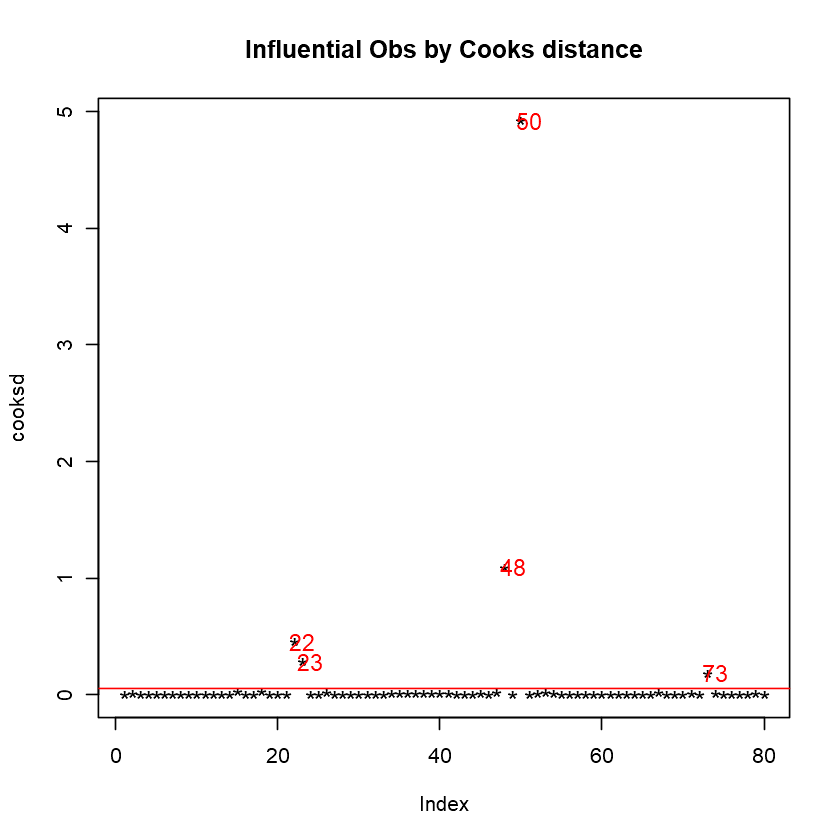

In [11]:
#outlier detection with Cook's distance

mod <- lm(Volume ~ Price + x4StarReviews + x2StarReviews + NegativeServiceReview,
          data = existing2017)

cooksd <- cooks.distance(mod)

plot(cooksd, pch="*", cex=1.3, main="Influential Obs by Cooks distance")

sample_size <- nrow(existing2017)

abline(h = 4/sample_size, col="red")

text( x = 1:length(cooksd) + 1, y = cooksd,
  labels = ifelse(cooksd > 4 / sample_size, names(cooksd), ""),
  col = "red", cex = 1.1, offset = 3)

influential <- as.numeric(names(cooksd)[(cooksd > (4/sample_size))])

In [12]:
#removing outliers "ProductNum" 150,198,148,123,122

existing2017 <- existing2017[-influential,]

### Building and Training Model

In [13]:
#data partition

set.seed(101)

#excluding "ProductNum"(character)

Produktnummer_com <- existing2017[,1]

#75% training data, 25% test data

existing2017 <- existing2017[,-1]

inTrain <- createDataPartition(y = existing2017$Volume,p = .75,list = FALSE)

training <- existing2017[ inTrain,]

testing <- existing2017[ -inTrain,]

In [14]:
#model training, using "caret" package

#cross validation with 3 repeats

options(warn=-1)
ctrl <- trainControl(method = "repeatedcv",
                     repeats = 3, summaryFunction = defaultSummary)

#training "Support Vector Machine" model

SVMfit <- train( Volume ~ .,data = training, method = "svmLinear2",
                 tuneLength = 5, trControl = ctrl)


In [15]:
options(warn=0)

#testing SVM model

predictions <- predict(SVMfit, newdata =testing)

pred_testing <- cbind(testing,predictions)

postResample(pred = pred_testing$predictions, obs = pred_testing$Volume)


RMSE    Rsquared         MAE 
138.2297798   0.9340886 102.0041085

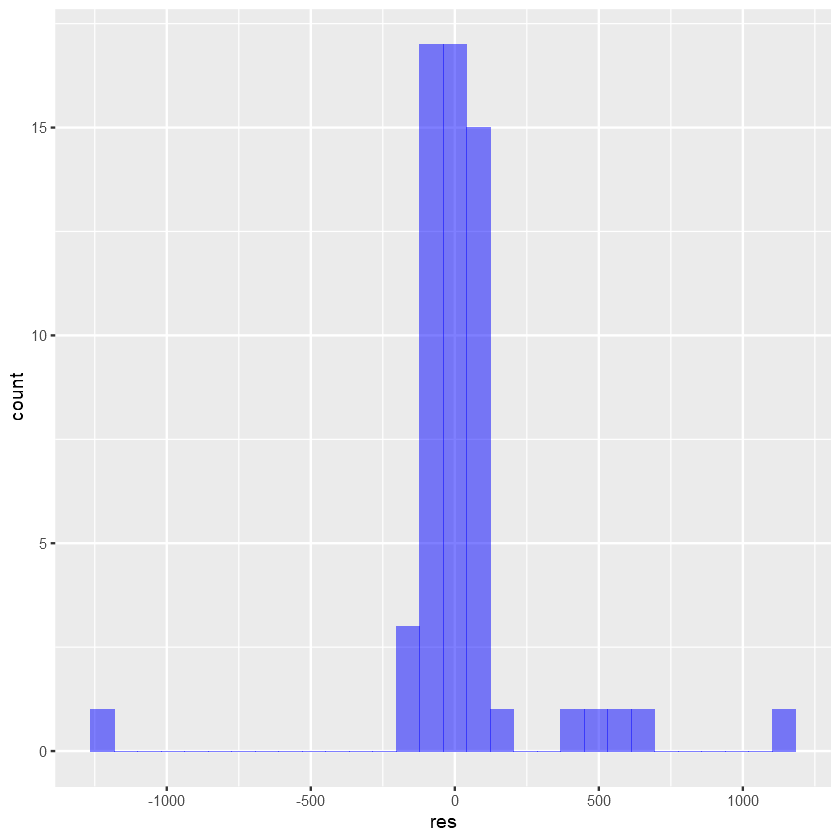

In [16]:
#plotting residuals

res <- residuals(SVMfit)

res <- as.data.frame(res)

ggplot(res,aes(res)) + geom_histogram(fill="blue",alpha=0.5,bins=30)

In [17]:
#Importance of Features

varImp(SVMfit)

loess r-squared variable importance

  only 20 most important variables shown (out of 23)

                              Overall
PositiveServiceReview        100.0000
x4StarReviews                 67.4860
x2StarReviews                 48.3352
NegativeServiceReview         31.5246
Recommendproduct              21.0963
ProfitMargin                  19.9870
ShippingWeight                18.1410
ProductHeight                 16.4743
ProductWidth                  16.4225
Price                         10.5103
ProductType.GameConsole       10.4215
ProductType.ExtendedWarranty  10.3831
ProductType.Printer            5.8185
ProductType.Accessories        4.8602
ProductType.PC                 3.3624
ProductType.PrinterSupplies    2.4966
ProductType.Software           2.1811
ProductType.Netbook            2.0939
ProductType.Laptop             1.4708
ProductType.Tablet             0.2511

In [109]:
#training "Random Forest" model

tunegrid <- expand.grid(.mtry = (1:5))

ctrl <- trainControl(method = "repeatedcv", repeats = 3,
               summaryFunction = defaultSummary, search='grid')

RFfit <- train(Volume ~ ., data = training, method = "rf",
               tuneGrid = tunegrid, trControl = ctrl, importance = TRUE)


In [111]:
#testing "Random Forest" model

predictions <- predict(RFfit, newdata =testing)

predictions <- round(predictions)

pred_testing <- cbind(testing,predictions)

postResample(pred = pred_testing$predictions, obs = pred_testing$Volume)

RMSE    Rsquared         MAE 
160.0790820   0.9055089 100.3125000

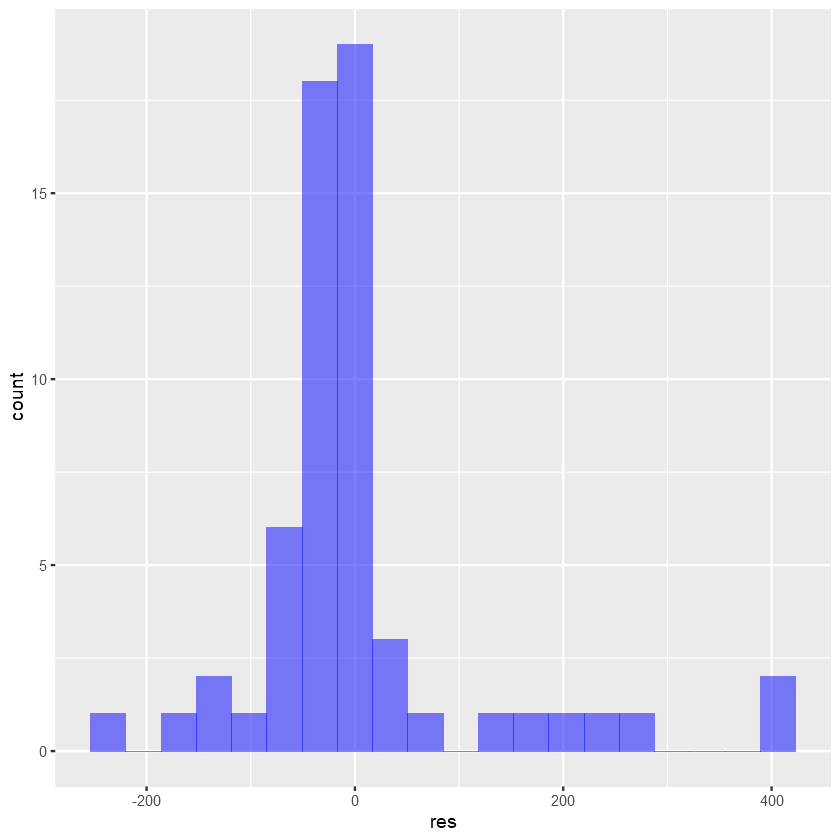

In [85]:
#plotting residuals to check distribution of errors

res <- residuals(RFfit)

res <- as.data.frame(res)

ggplot(res,aes(res)) + geom_histogram(fill="blue",alpha=0.5,bins=20)

In [86]:
#Importance of Features

varImp(RFfit)

rf variable importance

  only 20 most important variables shown (out of 23)

                             Overall
PositiveServiceReview         100.00
x4StarReviews                  75.72
x2StarReviews                  57.70
Recommendproduct               40.79
NegativeServiceReview          32.79
ProductDepth                   29.28
ShippingWeight                 28.60
ProductType.ExtendedWarranty   28.22
ProductWidth                   26.19
ProfitMargin                   23.21
ProductType.Display            20.69
ProductHeight                  18.57
ProductType.Accessories        17.07
ProductType.Software           16.14
ProductType.PC                 16.04
ProductType.Printer            15.62
ProductType.Netbook            14.33
ProductType.PrinterSupplies    13.69
ProductType.Laptop             12.70
Price                          10.07

In [87]:
####comparing models####

resamps <- resamples(list(svm = SVMfit, rf=RFfit))

summary(resamps)


Call:
summary.resamples(object = resamps)

Models: svm, rf 
Number of resamples: 30 

MAE 
        Min.   1st Qu.   Median     Mean  3rd Qu.     Max. NA's
svm 49.53112 122.50669 171.1456 201.2041 268.8708 504.1158    0
rf  42.25604  90.69189 141.7008 139.8323 182.3155 248.7306    0

RMSE 
        Min.  1st Qu.   Median     Mean  3rd Qu.     Max. NA's
svm 51.88863 185.9690 263.5186 341.4248 474.5143 891.6089    0
rf  50.84415 118.2171 204.5722 207.3404 291.5588 390.8911    0

Rsquared 
         Min.  1st Qu.    Median      Mean   3rd Qu.      Max. NA's
svm 0.4150119 0.806313 0.8972953 0.8412428 0.9617661 0.9928992    0
rf  0.7040206 0.837020 0.9330213 0.8957225 0.9626491 0.9964053    0


### Predicting Sales Volume 



In [125]:
#preparation of new data set

incomplete2017$ProductNum <- as.character(incomplete2017$ProductNum)

incomplete2017<-select(incomplete2017,-c('BestSellersRank'))

incomplete2017 <- select(incomplete2017,-c("x5StarReviews", "x3StarReviews", "x1StarReviews"))

In [126]:
#creating dummy variables

dummys <- dummyVars("~ ProductType",data=incomplete2017)

dummy <- data.frame(predict(dummys,newdata=incomplete2017))

incomplete2017 <- data.frame(incomplete2017,dummy)

incomplete2017 <- incomplete2017[,-1]

In [127]:
#predictions for sales volume

predicted_Volume <- round(predict(RFfit,newdata=incomplete2017))

Produktnummer_inc <- incomplete2017['ProductNum']

incomplete_results <- cbind(incomplete2017,predicted_Volume)

incomplete_results1 <- select(incomplete_results, ProductNum, Price, ProfitMargin, predicted_Volume)


ProductType <- incomplete2017[,1]

incomplete_results <- cbind(ProductType,incomplete_results1)


### Results

In [130]:
#predicting profitability

incomplete_results <- mutate(incomplete_results, Profit = round(Price * ProfitMargin * predicted_Volume))

select(incomplete_results, ProductNum, Price, predicted_Volume, Profit)

ProductNum,Price,predicted_Volume,Profit
171,699.00,416,72696
172,860.00,240,41280
173,1199.00,277,33212
175,1199.00,55,9892
176,1999.00,88,40460
178,399.99,88,2816
180,329.00,929,27508
181,439.00,314,15163
183,330.00,32,950
186,629.00,956,60132
